# Bayesian Statistics : Hamiltonien Monte Carlo

Use a colab or have a clean environment

## Setup and preprocessing pipeline

In [1]:
# !pip install pystan

In [ ]:
############
# Packages #
############
import os
import stan
import pywt
import nest_asyncio
import time as t
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go


import scipy.stats as stats
from pathlib import Path
from numba import njit, objmode
from scipy.special import logsumexp
from scipy.stats import rv_discrete
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from typing import Dict, Union, List, Tuple, Any, Callable, Optional
##########
# config #
##########

nest_asyncio.apply()
stan.auto_format = True

 ########
# Plot #
########
def my_pal(n):
    return sns.color_palette("flare", n).as_hex()

def add_fig(fig, signal, color, name):
    fig.add_trace(go.Scatter(y=signal,
                 mode="lines",
                 line=dict(
                     width=2,
                     color=color,
                 ),
                 opacity = 0.6,
                 name=name
                )
             )

def plot_signal(vec, title = "signal"):
    fig = px.line(vec, title = title)
    fig.show()

def plot_sample(
    sampling: np.ndarray,
    size: Optional[int] = 10,
    levels: Optional[int] = 20,
    title: Optional[str] = "sampling"
) -> None:
    """
    Plot a scatter plot and kernel density estimate of a 2D sampling.

    Args:
    - sampling (np.ndarray): 2D array representing the sampled data.
    - size (Optional[int]): Size of the figure (default is 10).
    - levels (Optional[int]): Number of levels in the contour plot (default is 20).
    - title (Optional[str]): Title of the plot (default is "sampling").

    Returns:
    None
    """
    fig_sampling = plt.figure(figsize=(size, size))
    plt.scatter(x = sampling[:,0], y = sampling[:,1], marker ="o", alpha = 0.1)
    sns.kdeplot(x = sampling[:,0], y = sampling[:,1], alpha = 1, levels = levels, cmap= "Blues" )
    plt.title(title)
    fig_sampling.show()

def plot_mcmc_traj(
    traj: np.ndarray,
    size: Optional[int] = 10,
    trajname: Optional[str] = "HM"
) -> None:
    """
    Plot the trajectory of an MCMC sampler.

    Args:
    - traj (np.ndarray): 2D array representing the MCMC trajectory.
    - size (Optional[int]): Size of the figure (default is 10).
    - trajname (Optional[str]): Name of the MCMC sampler (default is "HM").

    Returns:
    None
    """
    traj_length = traj.shape[0]
    dim = traj.shape[1]
    colors = sns.color_palette("viridis", traj_length).as_hex()
    plt.figure(figsize=(size, size))
    sns.set(style='dark')

    if dim==2 or dim > 5:
        plt.scatter(x = traj[:,0], y = traj[:,1], marker ="o", alpha = 0.5, color=colors)
    else:
        df = pd.DataFrame(traj, columns = np.arange(dim))
        df["step"] = np.arange(traj_length)
        sns.pairplot(df, hue="step", palette = colors)

    plt.title(f"Trajectory of the {trajname} sampler")
    plt.show()

def plot_ratio(ratios, trajname = "HM", size=10, batch=50):
    ma = np.cumsum(ratios)/batch
    ma[batch:] -= ma[:-batch]
    ma = ma[batch-1:]
    fig, ax = plt.subplots(figsize=(size, size))
    ax.plot(np.arange(batch-1,len(ratios)), ma)
    ax.set(ylim=(-0.05,1.05), xlabel="iteration", ylabel="acceptation ratio")
    fig.suptitle(f"Moving average of the acceptation ratio over iterations for the {trajname} sampler")
    plt.show()

def plot_autocorrelations(
    traj: np.ndarray,
    size: Optional[int] = 10,
    trajname: Optional[str] = "HM",
    nlags: Optional[int] = 80
) -> None:
    """
    Plot autocorrelations of an MCMC trajectory.

    Args:
    - traj (np.ndarray): 2D array representing the MCMC trajectory.
    - size (Optional[int]): Size of the figure (default is 10).
    - trajname (Optional[str]): Name of the MCMC sampler (default is "HM").
    - nlags (Optional[int]): Number of lags to plot (default is 80).

    Returns:
    None
    """
    dim = traj.shape[1]
    plt.figure(figsize=(size,size))
    for i in range(dim):
        pd.plotting.autocorrelation_plot(traj[:,i], label=f'Autocorrelation of dim {i}',linewidth=2)
    plt.title(f"Autocorrelations {trajname}")
    plt.xlim((0,nlags)) #limit lags
    plt.show()

def plot_hm_analyses(
    traj: np.ndarray,
    ratios: Union[np.ndarray, None],
    size: Optional[int] = 10,
    trajname: Optional[str] = "HM",
    nlags: Optional[int] = 80
) -> None:
    """
    Plot various analyses of an MCMC trajectory.

    Args:
    - traj (np.ndarray): 2D array representing the MCMC trajectory.
    - ratios (Union[np.ndarray, None]): Ratios data, if available.
    - size (Optional[int]): Size of the figures (default is 10).
    - trajname (Optional[str]): Name of the MCMC sampler (default is "HM").
    - nlags (Optional[int]): Number of lags to plot (default is 80).

    Returns:
    None
    """
    plot_mcmc_traj(traj, size=size, trajname=trajname)
    if ratios is not None:
        plot_ratio(ratios, trajname=trajname)
    plot_autocorrelations(traj, size=size, trajname=trajname, nlags=nlags)

def plot_hist(sample, title, nbins = 400):
    fig = px.histogram(sample,
                   histnorm='probability density',
                   title = title,
                   nbins = nbins
                  )
    fig.show()

def plot_all_st(df, title = "Times series"):
    pal = my_pal(df.shape[1])
    fig = go.Figure(
        layout=go.Layout(
            height=600,
            width=1000,
            title = title
    ))
    for i,col in enumerate(df):
        add_fig(fig, df[col], pal[i], col)
    fig.show()


########
# init #
########

def compute_vx(X):
    """Compute mean estimated variance of xt predictors

    Args:
        X (np.array): matrix of xt predictors

    Returns:
        float: mean estimated variance of xt predictors
    """
    return np.mean(np.var(X,axis=0))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w



#################
# Preprocessing #
#################

def denoise_1sign(sign, wavelet_thr=0.2):
    #decomposition en ondelette
    coeffs = pywt.wavedec(sign, "sym5", mode="per")
    #filtration qui s'apparente à une projection orthogonale
    coeffs[1:] = (pywt.threshold(coeff, value=wavelet_thr, mode="soft") for coeff in coeffs[1:])
    #reconstruction du signal filtré
    return pywt.waverec(coeffs, "sym5", mode="per" )

def denoise_signals(df, wavelet_thr=0.2):
    f_denoise = lambda sign : denoise_1sign(sign, wavelet_thr=wavelet_thr)
    mat = np.apply_along_axis(f_denoise, arr = df.to_numpy(), axis = 0 )
    return pd.DataFrame(mat, columns = df.columns, index=df.index)

def pca(mat, ncomp=5):
    pca = PCA(n_components=ncomp)
    reducted_mat = pca.fit_transform(mat)
    print("PCA variance ratios",pca.explained_variance_ratio_)
    print("PCA singular values",pca.singular_values_)
    return reducted_mat

def pca_df(df, ncomp=5):
    mat = pca(df.to_numpy(), ncomp=ncomp)
    time_lost = df.shape[0]-mat.shape[0]
    return pd.DataFrame(mat, columns = [ f"component {i+1}" for i in range(mat.shape[1])], index=df.index[time_lost:])

class PreprocessDataTrainTestSplit:
    def __init__(self, data_path, split_date, normalize=False, max_date=None, wavelet_thr =None, pca_ncomp=None, no_corr_col=False):
        self.data_path = data_path
        self.split_date = split_date
        self.normalize = normalize
        self.max_date = max_date
        self.wavelet_thr = wavelet_thr
        self.pca_ncomp =pca_ncomp
        self.no_corr_col =no_corr_col

    def process(self):
        df = pd.read_csv(self.data_path)
        df = df.iloc[1:,:]
        df["sasdate"] = pd.to_datetime(df["sasdate"], format='%m/%d/%Y')
        df.set_index("sasdate", inplace=True)


        if self.max_date is not None:
            df_filtered = df.loc[df.index <= self.max_date]
        else:
            df_filtered = df.copy()

        train_df = df_filtered[df_filtered.index <= self.split_date]
        test_df = df_filtered[df_filtered.index > self.split_date]

        df_y_train = train_df["INDPRO"]
        df_x_train = train_df.drop('INDPRO', axis=1).copy()

        df_y_test = test_df["INDPRO"]
        df_x_test = test_df.drop('INDPRO', axis=1).copy()

        ##Step1 : Process nan values
        #Drop columns with too many nan
        col_to_drop = ['ACOGNO', 'TWEXMMTH', 'UMCSENTx', 'ANDENOx']
        if self.no_corr_col:
          col_to_drop = col_to_drop + ['IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPMAT',  'IPNMAT', 'IPMANSICS']
          # col_indus = list(train_df.columns[train_df.columns.str.contains('IP')])
          # col_to_drop = col_to_drop + col_indus
        column_transformer = ColumnTransformer(
            transformers=[('drop_columns', 'drop', col_to_drop)],
            remainder='passthrough'
        )
        #Replace nan values by median for others
        imputer = SimpleImputer(strategy='median')

        #Convert numpy arrays to Pandas DataFrame
        to_df = FunctionTransformer(lambda x: pd.DataFrame(x, columns=df_x_train.columns.drop(col_to_drop)), validate=False)

        pipeline_drop_imputer = Pipeline([
            ('preprocessor', column_transformer),
            ('imputer', imputer),
            ('to_dataframe', to_df)
        ])

        df_x_train_transform = pipeline_drop_imputer.fit_transform(df_x_train)
        df_x_test_transform = pipeline_drop_imputer.transform(df_x_test)

        df_x_train_transform["sasdate"] = df_x_train.index
        df_x_train_transform.set_index("sasdate", inplace=True)
        df_x_test_transform["sasdate"] = df_x_test.index
        df_x_test_transform.set_index("sasdate", inplace=True)

        # denoising and pca
        b1 = self.wavelet_thr is not None
        b2 = self.pca_ncomp is not None

        if b1 or b2:
          if b1:
            df_x_train_transform = denoise_signals(df_x_train_transform, wavelet_thr=self.wavelet_thr)
            df_x_test_transform = denoise_signals(df_x_test_transform, wavelet_thr=self.wavelet_thr)
            # df_y_train = pd.DataFrame({"INDPRO":denoise_1sign(df_y_train, wavelet_thr=self.wavelet_thr)})
            # df_y_test = pd.DataFrame({"INDPRO":denoise_1sign(df_y_test, wavelet_thr=self.wavelet_thr)})
          if b2:
            df_x_train_transform = pca_df(df_x_train_transform, ncomp=self.pca_ncomp)
            df_x_test_transform = pca_df(df_x_test_transform, ncomp=self.pca_ncomp)

        df_train_transform = df_x_train_transform.copy()
        df_train_transform["INDPRO"] = df_y_train.values
        df_test_transform = df_x_test_transform.copy()
        df_test_transform["INDPRO"] = df_y_test.values

        plot_all_st(df_train_transform, title = "Train set before differentiation and standardization")

        ##Step 2 : first-order differenciation
        df_train_transform_diff = df_train_transform.diff().drop(index=df_train_transform.index[0], axis=0, inplace=False)
        df_test_transform_diff = df_test_transform.diff().drop(index=df_test_transform.index[0], axis=0, inplace=False)

        if self.normalize:
        ##Step3: features standardization
            df_y_train_transform_diff = df_train_transform_diff["INDPRO"]
            df_x_train_transform_diff = df_train_transform_diff.drop('INDPRO', axis=1).copy()

            df_y_test_transform_diff = df_test_transform_diff["INDPRO"]
            df_x_test_transform_diff = df_test_transform_diff.drop('INDPRO', axis=1).copy()

            scaler = StandardScaler()
            to_df = FunctionTransformer(lambda x: pd.DataFrame(x, columns=df_x_train.columns.drop(col_to_drop)), validate=False)

            pipeline_scaler = Pipeline([
                ('scaler', scaler),
                ('to_dataframe', to_df)
            ])

            df_x_train_clean_diff_stand = pipeline_scaler.fit_transform(df_x_train_transform_diff)
            df_x_test_clean_diff_stand = pipeline_scaler.transform(df_x_test_transform_diff)

            df_x_train_clean_diff_stand["sasdate"] = df_x_train_transform_diff.index
            df_x_train_clean_diff_stand.set_index("sasdate", inplace=True)
            df_x_test_clean_diff_stand["sasdate"] = df_x_test_transform_diff.index
            df_x_test_clean_diff_stand.set_index("sasdate", inplace=True)

            df_train_clean_diff_stand = df_x_train_clean_diff_stand.copy()
            df_train_clean_diff_stand["INDPRO"] = df_y_train_transform_diff.values
            df_test_clean_diff_stand = df_x_test_clean_diff_stand.copy()
            df_test_clean_diff_stand["INDPRO"] = df_y_test_transform_diff.values

            return df_train_clean_diff_stand, df_test_clean_diff_stand

        else:
            return df_train_transform_diff, df_test_transform_diff

## Industrial production predictions using HMC NUTS

### Loading and preprocessing

In [ ]:
root_path = Path(os.getcwd())
data_path = root_path.joinpath("Macro1.csv")

preprocess_train_test = PreprocessDataTrainTestSplit(data_path=data_path, split_date='1999-12-01', normalize=False, max_date='2006-12-31', wavelet_thr=None, pca_ncomp=None, no_corr_col=True) # thrs 0.5
train_df, test_df = preprocess_train_test.process()


X = train_df.drop('INDPRO', axis=1).values
y = train_df['INDPRO'].values

X_test = test_df.drop('INDPRO', axis=1).values
y_test = test_df['INDPRO'].values

In [ ]:
plot_all_st(train_df, title = "Times series train set")

### Model and Cross Validation

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 33, column 23: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 27, column 2: The
    parameter q is on the left-hand side of more than one tilde statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!


(86,) (86,)
Train R2: 0.6747058892504469
Train MSE: 0.0273557561194771
Val R2: 0.5180089311115719
Val MSE: 0.04179410717390988


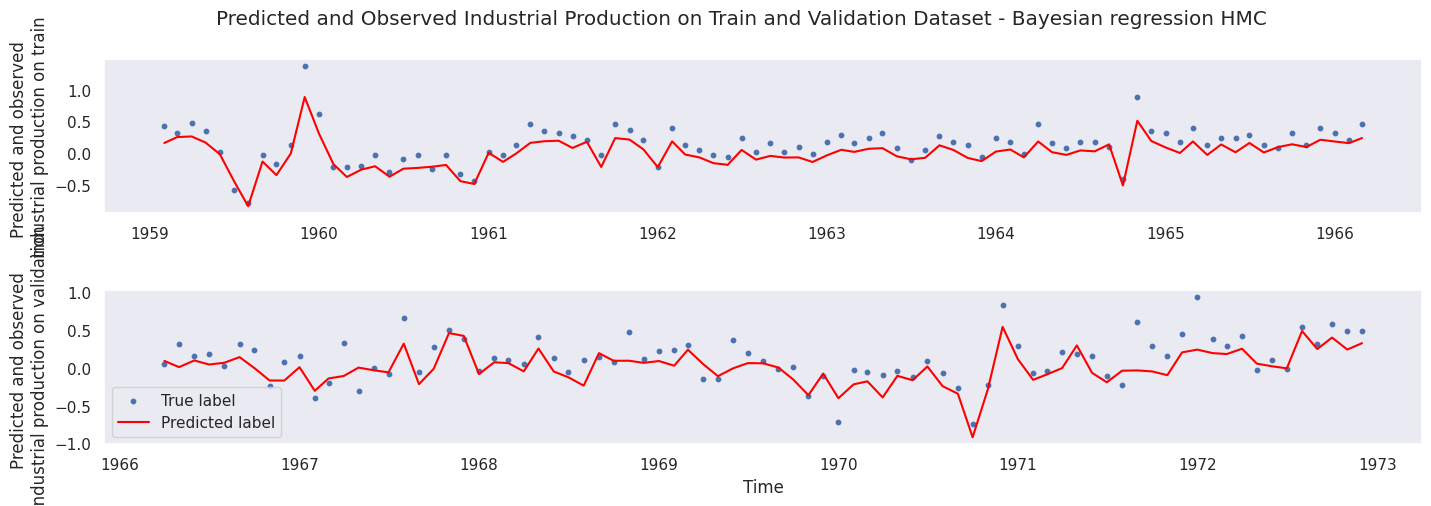

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 33, column 23: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 27, column 2: The
    parameter q is on the left-hand side of more than one tilde statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000125 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.25 seconds.
  Adjust your expectations accordingly!


(167,) (167,)
Train R2: 0.7210124853862674
Train MSE: 0.023834988079388886
Val R2: 0.6478316296764022
Val MSE: 0.06219648031832218


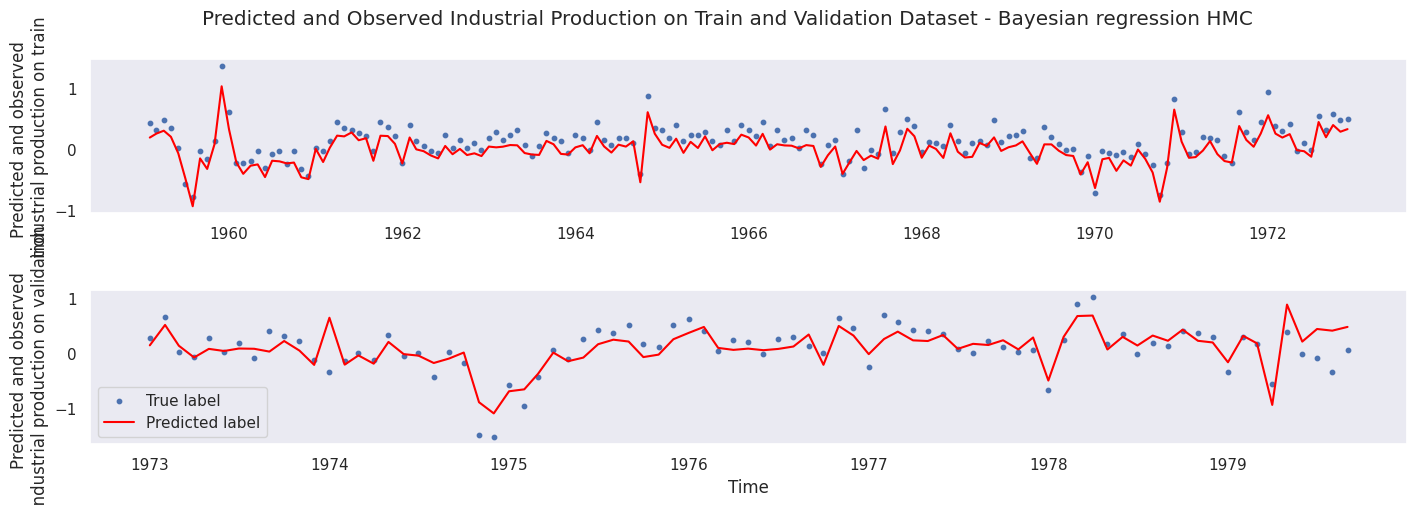

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 33, column 23: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 27, column 2: The
    parameter q is on the left-hand side of more than one tilde statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!


(248,) (248,)
Train R2: 0.8272476834386974
Train MSE: 0.019949037633086055
Val R2: 0.7174083219366059
Val MSE: 0.05276474115034019


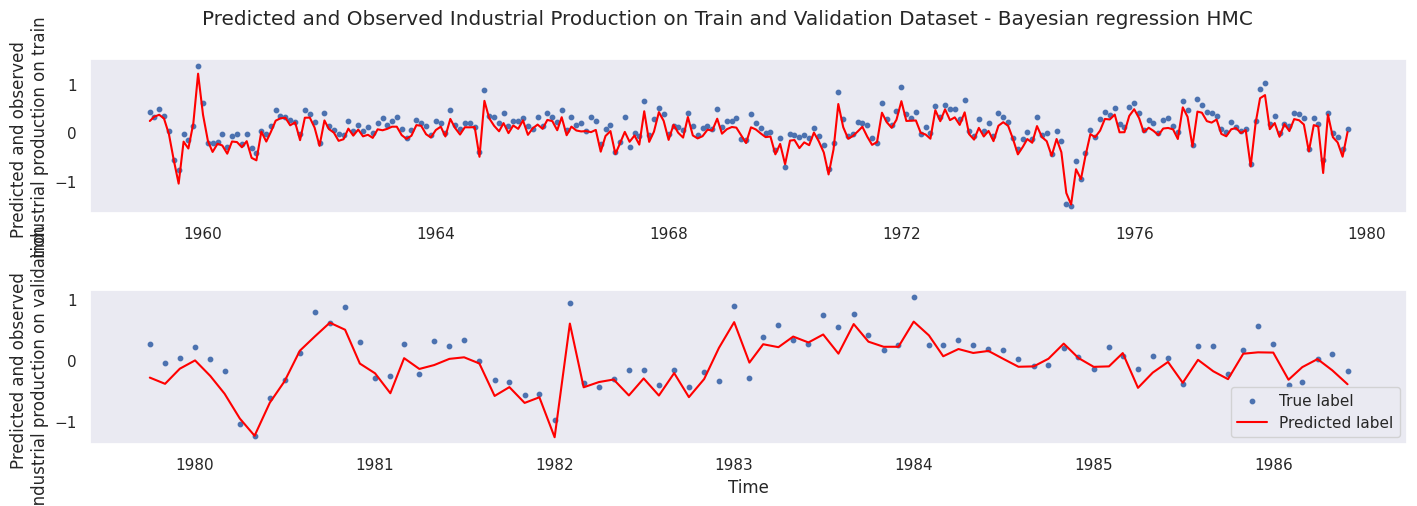

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 33, column 23: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 27, column 2: The
    parameter q is on the left-hand side of more than one tilde statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000105 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
  Adjust your expectations accordingly!


(329,) (329,)
Train R2: 0.8752240011341093
Train MSE: 0.016728943785955814
Val R2: 0.6391235960473391
Val MSE: 0.03583466224857063


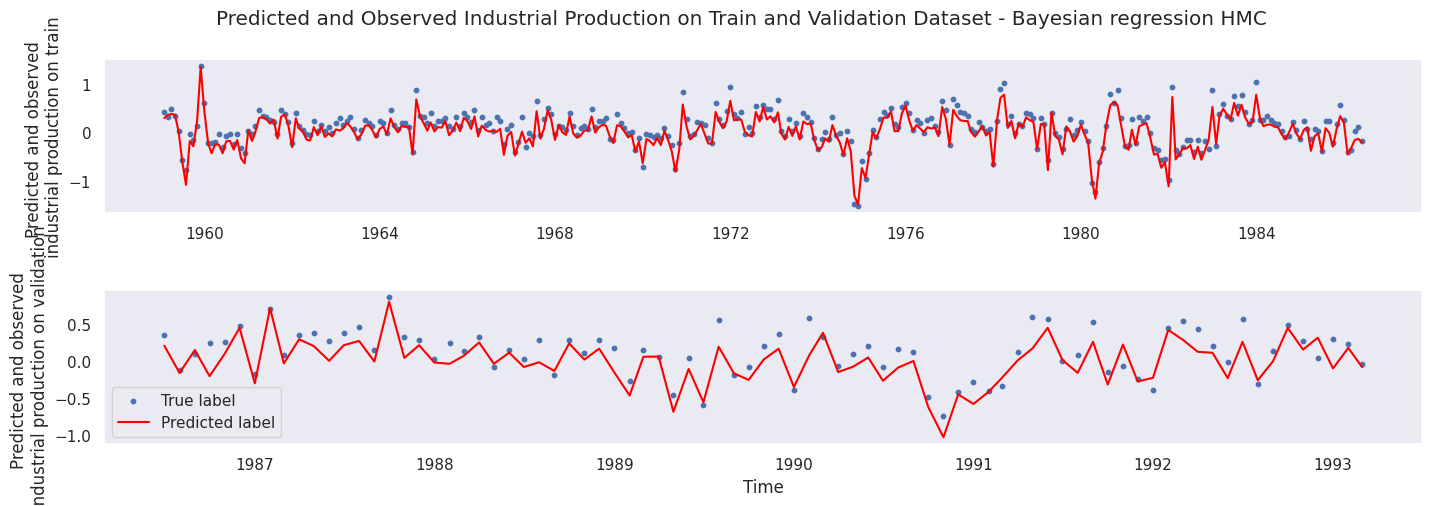

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 33, column 23: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 27, column 2: The
    parameter q is on the left-hand side of more than one tilde statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000149 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.49 seconds.
  Adjust your expectations accordingly!


(410,) (410,)
Train R2: 0.855191672806427
Train MSE: 0.018430468438325492
Val R2: 0.6547119265161979
Val MSE: 0.05028388626851238


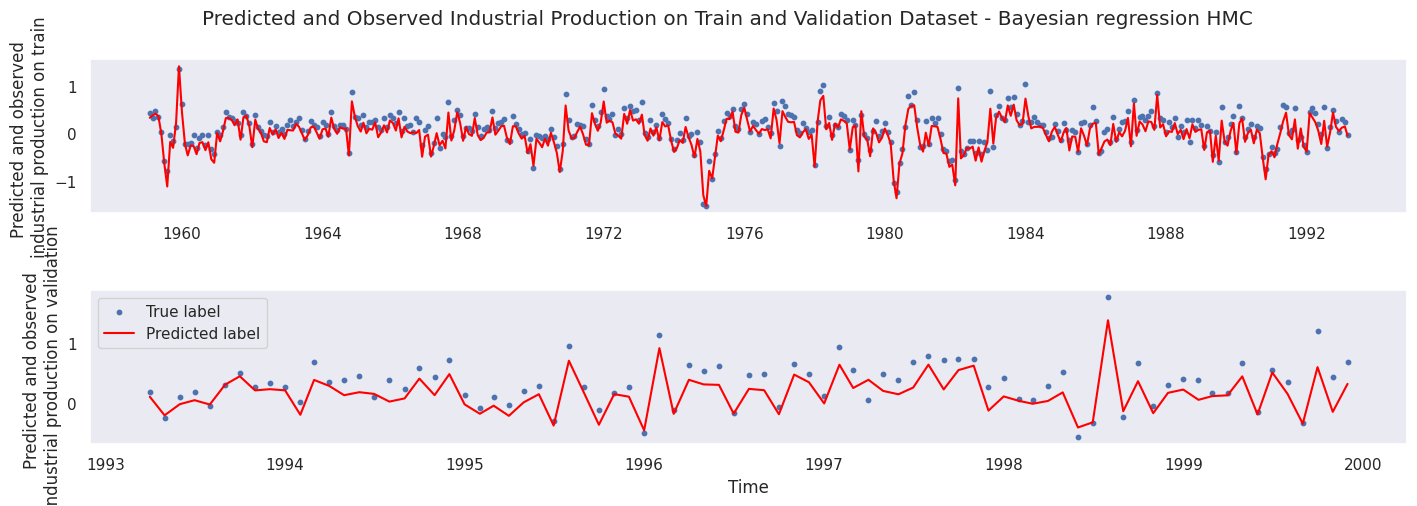

Average MSE - train: 0.02125983881124667
Average R2 - train: 0.7906763464031895
Average MSE - validation: 0.04857477543193105
Average R2 - validation: 0.6354168810576233
__________________________2000-2007_____________________________________
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 33, column 23: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_1n76b_yz/model_q63klhmv.stan', line 27, column 2: The
    parameter q is on the left-hand side of more than one tilde statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000122 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.22 seconds.
  Adjust your expectations accordingly!


Train R2: 0.789083014952957
Test R2: 0.6156924031034106
Train MSE: 0.028919585340967592
Test MSE: 0.08924839481513235


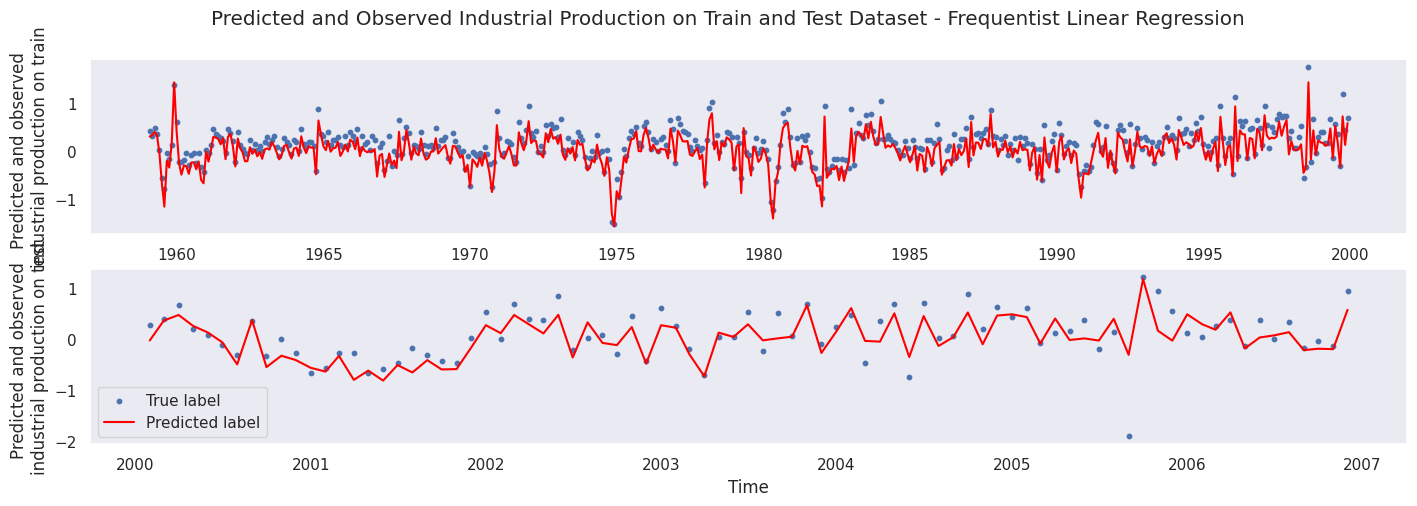

In [ ]:
bayesian_model_macro = """
data {
  int<lower=0> k;
  int<lower=0> T;
  array [T] real y;
  matrix [T,k] X;
  real<lower=0> vx;

  int<lower=0> a;
  int<lower=0> b;
  int<lower=0> A;
  int<lower=0> B;
}

parameters {
  real <lower=0, upper=1>q;
  real <lower=0, upper=1>R2;
  real sigma;
  vector [k] beta;
}

transformed parameters {
  real gamma =  sqrt(R2 / ((1-R2)*q*k*vx) );
}

model {
  q ~ beta(a, b);
  R2 ~ beta(A, B);
  target += -2 * log(sigma);
  target += log_mix(q,
                  normal_lpdf(beta | 0, sigma * gamma),
                  normal_lpdf(beta |0, 0.0001));
  y ~ normal( X* beta, sigma);
}
"""

def comput_Y_pred(df, X):
  betas = df.loc[:, df.columns.str.startswith('beta')].values
  return np.mean(X @ betas.T, axis=1)

tscv = TimeSeriesSplit(n_splits=5)
list_mse_train = []
list_r2_train = []
list_mse_val = []
list_r2_val = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    scaler = StandardScaler()
    X_train_transform = scaler.fit_transform(X_train)
    X_val_transform = scaler.transform(X_val)

    # LR.fit(X_train_transform, y_train)

    data_macro = {"k" : X_train_transform.shape[1], "T" : X_train_transform.shape[0],  "y" : y_train, "X" : X_train_transform, "vx" : compute_vx(X_train_transform),
            "a":1, "b":1, "A":1, "B":1 }

    posterior_macro = stan.build(bayesian_model_macro, data=data_macro, random_seed=1)
    df_sample = posterior_macro.sample(num_chains=1, num_samples=2000).to_frame()
    y_pred_train = comput_Y_pred(df_sample, X_train_transform)
    y_pred_val = comput_Y_pred(df_sample, X_val_transform)

    # y_pred_train = LR.predict(X_train_transform)
    # y_pred_val = LR.predict(X_val_transform)
    print(y_train.shape, y_pred_train.shape)
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    list_mse_train.append(mse_train)
    list_r2_train.append(r2_train)
    list_mse_val.append(mse_val)
    list_r2_val.append(r2_val)

    print("Train R2: {}".format(r2_train))
    print("Train MSE: {}".format(mse_train))
    print("Val R2: {}".format(r2_val))
    print("Val MSE: {}".format(mse_val))

    plt.figure(figsize=(17,5))
    plt.subplot(2, 1, 1)
    plt.scatter(train_df.index[train_index], y_train, marker='o', s=10, label="True label")
    plt.plot(train_df.index[train_index], y_pred_train, color='red', label="Predicted label")
    plt.ylabel("Predicted and observed \nindustrial production on train")

    plt.subplot(2, 1, 2)
    plt.scatter(train_df.index[val_index], y_val, marker='o', s=10, label="True label")
    plt.plot(train_df.index[val_index], y_pred_val, color='red', label="Predicted label")
    plt.xlabel('Time')
    plt.ylabel("Predicted and observed \nindustrial production on validation")
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Predicted and Observed Industrial Production on Train and Validation Dataset - Bayesian regression HMC")
    plt.legend()
    plt.show()

print("Average MSE - train: {}".format(sum(list_mse_train)/len(list_mse_train)))
print("Average R2 - train: {}".format(sum(list_r2_train)/len(list_r2_train)))
print("Average MSE - validation: {}".format(sum(list_mse_val)/len(list_mse_val)))
print("Average R2 - validation: {}".format(sum(list_r2_val)/len(list_r2_val)))


# Test 2000-2007
print("__________________________2000-2007_____________________________________")
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
X_test_transform = scaler.transform(X_test)

data_macro_2000 = {"k" : X_transform.shape[1], "T" : X_transform.shape[0],  "y" : y, "X" : X_transform, "vx" : compute_vx(X_transform),
            "a":1, "b":1, "A":1, "B":1 }

posterior_macro_2000 = stan.build(bayesian_model_macro, data=data_macro_2000, random_seed=1)
df_sample_2000 = posterior_macro_2000.sample(num_chains=1, num_samples=2000).to_frame()
y_pred_train_2000 = comput_Y_pred(df_sample_2000, X_transform)
y_pred_test_2000 = comput_Y_pred(df_sample_2000, X_test_transform)

r2_train = r2_score(y, y_pred_train_2000)
r2_test = r2_score(y_test, y_pred_test_2000)
mse_train = mean_squared_error(y, y_pred_train_2000)
mse_test = mean_squared_error(y_test, y_pred_test_2000)

print("Train R2: {}".format(r2_train))
print("Test R2: {}".format(r2_test))
print("Train MSE: {}".format(mse_train))
print("Test MSE: {}".format(mse_test))

plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(train_df.index, y, marker='o', s=10, label="True label")
plt.plot(train_df.index, y_pred_train_2000, color='red', label="Predicted label")
plt.ylabel("Predicted and observed \nindustrial production on train")

plt.subplot(2, 1, 2)
plt.scatter(test_df.index, y_test, marker='o', s=10, label="True label")
plt.plot(test_df.index, y_pred_test_2000, color='red', label="Predicted label")
plt.xlabel('Time')
plt.ylabel("Predicted and observed \nindustrial production on test")

plt.suptitle("Predicted and Observed Industrial Production on Train and Test Dataset - Frequentist Linear Regression")
plt.legend()
plt.show()

### HMC sampling plots

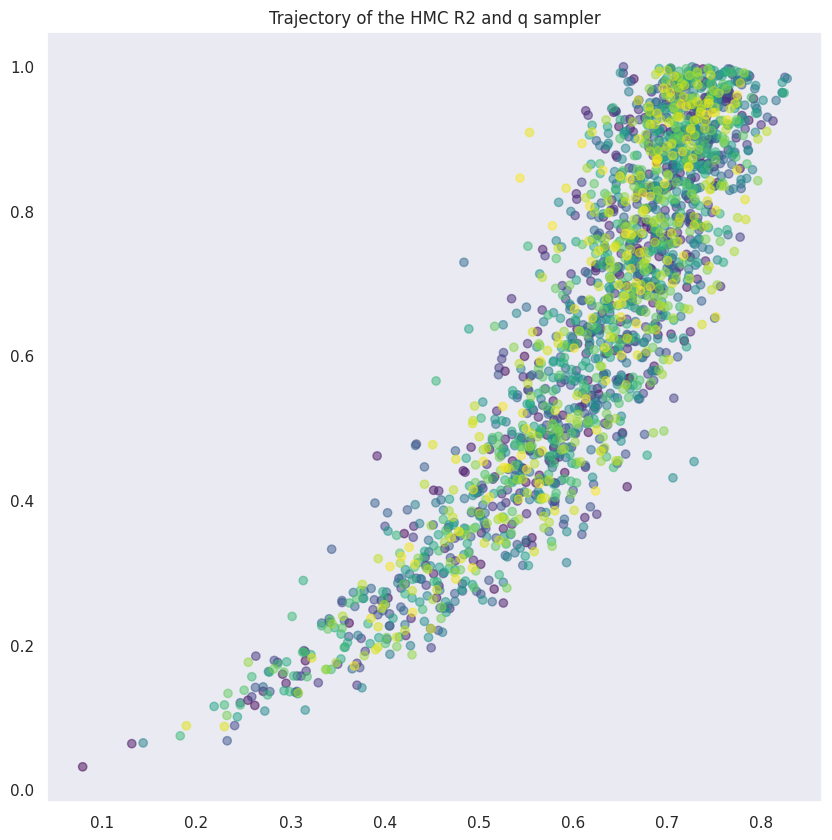

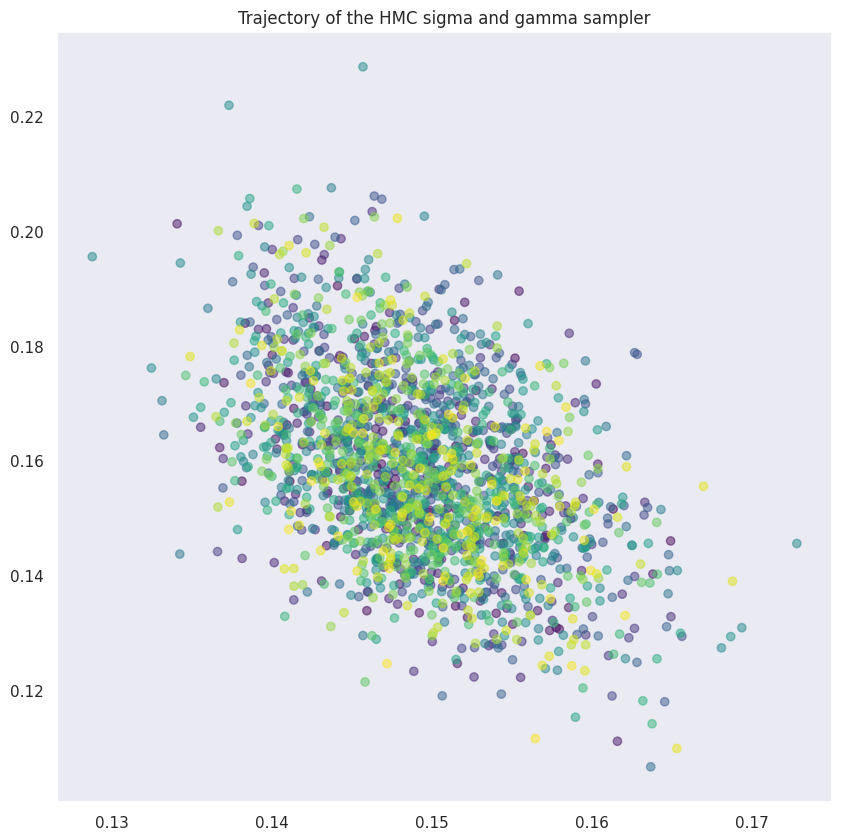

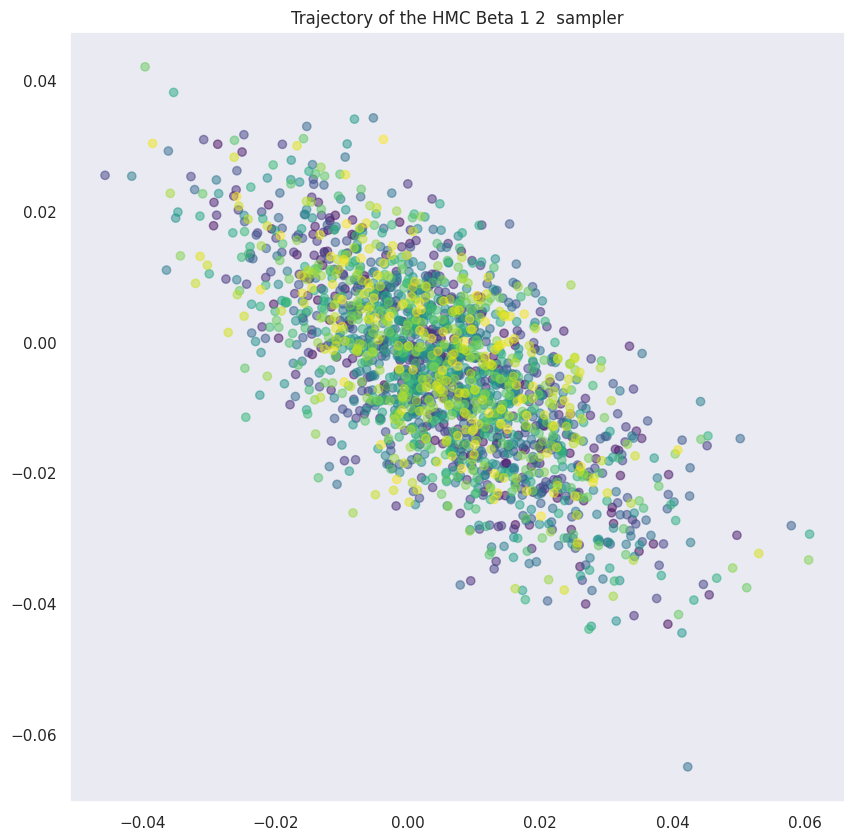

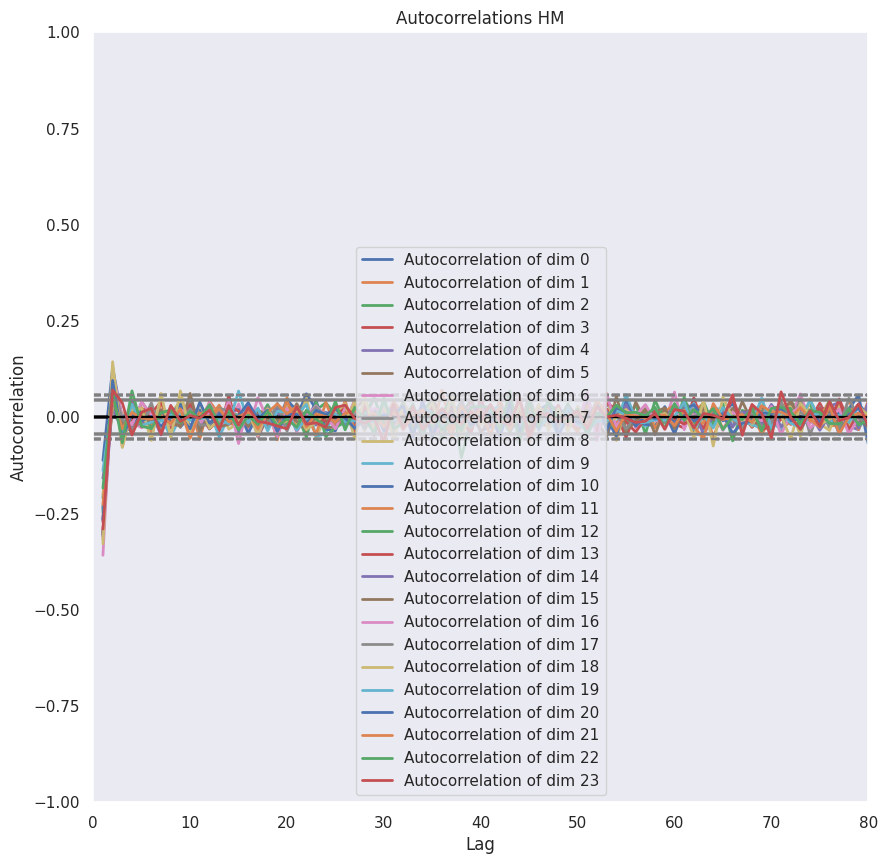

In [ ]:
plot_signal(moving_average(df_sample.accept_stat__, 50) , "acceptance rate HMC")
plot_mcmc_traj(df_sample.loc[:, ["R2", "q"]].values, trajname = "HMC R2 and q")
plot_mcmc_traj(df_sample.loc[:, ["sigma", "gamma"]].values, trajname = "HMC sigma and gamma")
plot_mcmc_traj(df_sample.loc[:, ["beta.1", "beta.2"]].values, trajname = "HMC Beta 1 2 ")
plot_autocorrelations(df_sample.iloc[:,7::5].values)